# Blog Generation

In [94]:
from dotenv import load_dotenv
load_dotenv()
from IPython.display import Markdown

In [95]:
from pydantic import BaseModel, Field
from typing_extensions import TypedDict,Optional
from typing import List,Annotated, Literal

from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage
from langchain_anthropic import ChatAnthropic
from langgraph.graph.message import add_messages


In [159]:
class BlogState(TypedDict):
    user_message: str # Annotated[List[str], add_messages]
    youtube_url: Optional[str]
    youtube_transcript: str
    blog_title: str
    blog_content: str
    final_blog: str

### Query Router

In [160]:
class QueryRouter(BaseModel):
    next_step: Literal["youtube", "assistant"] = Field(
        description=(
            "Determines the routing path for the user query:\n"
            "- 'youtube': When the user provides a YouTube URL\n" #  and requests blog generation
            "- 'assistant': When the user asks general questions or requires direct assistance"
        )
    )

In [161]:
llm = ChatAnthropic(model="claude-3-7-sonnet-latest")

In [162]:
def query_router(state: BlogState) -> dict:
    print(f"\n\{'--'*10}  QUERY ROUTER  {'--'*10}\n\n")
    try:
        message = state.get('user_message')
        print(message)
        print(type(message))
        if not message:
            raise ValueError("User message is missing from state")

        system_msg = SystemMessage(
            content=(
                "You are a routing agent that directs user queries to appropriate handlers.\n\n"
                "Rules for routing:\n"
                "1. Return 'youtube' if:\n"
                "   - The user message contains a YouTube URL/link AND\n"
                "   - They're requesting to generate or create a blog post\n\n"
                "   - Or if the user message contain only youTube URL\n\n"
                "2. Return 'assistant' if:\n"
                "   - The user is asking general questions\n"
                "   - Any other type of request\n"
                "   - No YouTube URL is present\n\n"
                "Always return exactly one of these two options: 'youtube' or 'assistant'"
            )
        )
        print("E1")
        human_msg = HumanMessage(content=message)
        
        try:
            router_llm = llm.with_structured_output(schema=QueryRouter)
            response = router_llm.invoke(
                input=[system_msg, human_msg]
            )
            next_step = response.next_step
            if next_step == "youtube":
                return "youtube"
            elif next_step == "assistant":
                return "assistant"
            
        except Exception as e:
            raise RuntimeError(f"LLM invocation failed: {str(e)}")
            
    except Exception as e:
        raise RuntimeError(f"Query routing failed: {str(e)}")

In [163]:
# query_router({
#     'user_message': "Write a blog on this youtube url: https://youtu.be/N0S5mcGjC30?si=eo-0aSqKSvL9j8Qo"
# })

In [164]:
# query_router({
#     'user_message': "https://youtu.be/N0S5mcGjC30?si=eo-0aSqKSvL9j8Qo"
# })

In [165]:
# query_router({
#     'user_message': "How to make you tube videos"
# })

### Get YouTue URL

In [166]:
class YouTubeURL(BaseModel):
    url: str = Field(
        description="Valid YouTube URL extracted from the user message",
    )

In [167]:
def get_youtube_url(state: BlogState):
    print(f"\n\{'--'*10}  GET YOUTUBE URL  {'--'*10}\n\n")
    try:
            
        message = state.get('user_message')
        if not message:
            raise ValueError("User message is missing from state")

        system_msg = SystemMessage(
            content=(
                "Extract YouTube URLs from the user message following these rules:\n"
                "1. Only extract valid YouTube URLs (full URLs or youtu.be format)\n"
                "2. Return exactly one URL without any additional text\n"
                "3. Ensure the URL contains a valid video ID\n"
                "4. Do not modify or transform the original URL\n"
                "5. If multiple URLs exist, extract the first valid one\n"
                "6. If no valid YouTube URL is found, return None"
            )
        )
        
        human_msg = HumanMessage(content=message)
        
        try:
            url_getter_llm = llm.with_structured_output(schema=YouTubeURL)
            response = url_getter_llm.invoke(
                input=[system_msg, human_msg]
            )

            print(response.url)
            
            if (response.url == "None") or (not response.url):
                return {'youtube_url': None}
                
            return {'youtube_url': response.url}
            
        except Exception as e:
            raise RuntimeError(f"URL extraction failed: {str(e)}")
            
    except Exception as e:
        raise RuntimeError(f"YouTube URL extraction process failed: {str(e)}")

In [168]:
# get_youtube_url({
#     'user_message': "Write a blog on this youtube url: https://youtu.be/N0S5mcGjC30?si=eo-0aSqKSvL9j8Qo"
# })

In [169]:
# get_youtube_url({
#     'user_message': "Write a blog on this youtube url: "
# })

### Transcript extract

In [170]:
from urllib.parse import urlparse, parse_qs
from youtube_transcript_api import (
    YouTubeTranscriptApi,
    NoTranscriptFound,
    TranscriptsDisabled,
    VideoUnavailable
)

import re
from typing import Dict, Optional

In [171]:
urlparse("https://www.youtube.com/watch?v=dQw4w9WgXcQ")

ParseResult(scheme='https', netloc='www.youtube.com', path='/watch', params='', query='v=dQw4w9WgXcQ', fragment='')

In [172]:
urlparse("https://www.youtube.com/watch?v=dQw4w9WgXcQ&t=42s")

ParseResult(scheme='https', netloc='www.youtube.com', path='/watch', params='', query='v=dQw4w9WgXcQ&t=42s', fragment='')

In [173]:
urlparse("https://www.youtube.com/embed/dQw4w9WgXcQ")

ParseResult(scheme='https', netloc='www.youtube.com', path='/embed/dQw4w9WgXcQ', params='', query='', fragment='')

In [174]:
def extract_video_id(url: str) -> str:
    try:
        if 'youtu.be' in url:
            return url.split('/')[-1].split('?')[0]
        
        parsed_url = urlparse(url)
        if 'youtube.com' in parsed_url.netloc:
            if 'watch' in parsed_url.path:
                return parse_qs(parsed_url.query)['v'][0]
            elif 'embed' in parsed_url.path:
                return parsed_url.path.split('/')[-1]
            
        raise ValueError("Invalid YouTube URL format")
        
    except Exception as e:
        raise ValueError(f"Failed to extract video ID: {str(e)}")

In [175]:
extract_video_id("https://www.youtube.com/watch?v=dQw4w9WgXcQ")

'dQw4w9WgXcQ'

In [176]:
extract_video_id("https://www.youtube.com/watch?v=dQw4w9WgXcQ&t=42s")

'dQw4w9WgXcQ'

In [177]:
extract_video_id("https://www.youtube.com/embed/dQw4w9WgXcQ")

'dQw4w9WgXcQ'

In [178]:
def clean_transcript_text(text: str) -> str:

    # Remove multiple newlines
    text = re.sub(r'\n\s*\n', '\n', text)
    # Remove special characters but keep basic punctuation
    text = re.sub(r'[^\w\s.,!?-]', '', text)
    # Normalize whitespace
    text = ' '.join(text.split())
    return text

In [179]:
def get_transcript(state: BlogState):
    print(f"\n\{'--'*10}  GET YOUTUBE TRANSCRIPT  {'--'*10}\n\n")
    try:    
        url = state.get('youtube_url')
        if not url:
            raise ValueError("YouTube URL is missing from state")

        video_id = extract_video_id(url)
        
        try:
            transcript = YouTubeTranscriptApi.get_transcript(
                video_id=video_id,
                languages=['en'] 
            )
            
            content = "\n".join(subtitle.get('text', '').strip() for subtitle in transcript if subtitle.get('text'))
            
            cleaned_content = clean_transcript_text(content)
            
            if not cleaned_content:
                raise ValueError("Empty transcript after processing")
                
            return {'youtube_transcript': cleaned_content}
            
        except NoTranscriptFound:
            raise RuntimeError("No transcript available for this video")
        except TranscriptsDisabled:
            raise RuntimeError("Transcripts are disabled for this video")
        except VideoUnavailable:
            raise RuntimeError("Video is unavailable or private")
        except Exception as e:
            raise RuntimeError(f"Failed to extract transcript: {str(e)}")
            
    except Exception as e:
        raise RuntimeError(f"Transcript extraction process failed: {str(e)}")

In [180]:
# t = get_transcript(
#     {
#         'youtube_url': "https://www.youtube.com/watch?v=Tx0Y3qb9ZUc"
#     }
# )

In [181]:
# print(t['youtube_transcript'])

### Title Generation

In [182]:
class BlogTitle(BaseModel):
    title: str = Field(
        description=(
            "A compelling, SEO-friendly blog title derived from video transcript content.\n"
            "Should be:\n"
            "- Between 40-60 characters long\n"
            "- Contain main keywords from the transcript\n"
            "- Be engaging but not clickbait\n"
            "- Use proper capitalization\n"
            "- Avoid special characters except '?', ':', '-'"
        )
    )


In [183]:
def generate_youtube_title(state: BlogState):
    print(f"\n\{'--'*10}  GENERATE YOUTUBE TITLE  {'--'*10}\n\n")
    try:            
        transcript = state.get("youtube_transcript")

        if not transcript or not isinstance(transcript, str):
            raise ValueError("Valid transcript is required for title generation")
            

        system_msg = SystemMessage(
            content=(
                "You are an expert blog title generator optimizing for both engagement and SEO.\n\n"
                "Guidelines for title generation:\n"
                "1. Analyze the transcript for main topic, key points, and unique insights\n"
                "2. Create a title that accurately reflects the content\n"
                "3. Use power words that drive engagement\n"
                "4. Include relevant keywords for SEO\n"
                "5. Maintain professional tone - no clickbait or sensationalism\n"
                "6. Use proper grammar and capitalization\n"
                "7. Keep length between 40-60 characters\n"
                "8. Make it compelling but honest\n\n"
                "Focus on creating a title that would make readers want to learn more while "
                "accurately representing the content."
            )
        )
        
        human_msg = HumanMessage(
            content=(
                "Please analyze this video transcript and generate an optimal blog title.\n\n"
                "Consider these aspects while analyzing:\n"
                "- Main topic and key message\n"
                "- Target audience\n"
                "- Unique insights or valuable information\n"
                "- Professional context\n\n"
                f"Transcript:\n{transcript}"
            )
        )
        
        try:
            title_generator_llm = llm.with_structured_output(schema=BlogTitle)
            response = title_generator_llm.invoke(
                input=[system_msg, human_msg]
            )
            
            return {'blog_title': response.title}
            
        except Exception as e:
            raise RuntimeError(f"Title generation failed: {str(e)}")
            
    except Exception as e:
        raise RuntimeError(f"Blog title generation process failed: {str(e)}")

In [184]:
# generate_youtube_title(t)

### Blog Generation

In [185]:
def generate_blog_content(state: BlogState):

    print(f"\n\{'--'*10}  GENERATE BLOG CONTENT  {'--'*10}\n\n")
    try:            
        transcript = state.get("youtube_transcript")
        if not transcript or not isinstance(transcript, str):
            raise ValueError("YouTube transcript is missing or invalid")

        system_msg = SystemMessage(
            content=(
                "You are an expert blog content writer specializing in creating engaging, "
                "informative, and well-structured articles from youtube video transcript.\n\n"
                "Use only provided youtube transcript for blog generation.\n\n"
                "Guidelines for blog generation:\n"
                "1. Create clear section hierarchy with relevant subheadings\n"
                "2. Maintain consistent tone and style throughout\n"
                "3. Expand on key points with examples and context\n"
                "4. Use transitional phrases between sections\n"
                "5. Include relevant examples and explanations\n"
                "6. Optimize content for both readability and SEO\n"
                "7. Ensure each section provides unique value\n"
                "8. Write in an engaging but professional tone\n"
                "9. Use short paragraphs and clear language\n"
                "10. Add relevant context where the video may lack detail\n\n"
                "Focus on creating content that is both informative and engaging while "
                "maintaining the original message of the video.\n\n"
                "Format your response using markdown for better readability."
            )
        )
        
        human_msg = HumanMessage(
            content=(
                f"Please generate a comprehensive blog post based on this video transcript.\n\n"
                "Requirements:\n"
                "- Create an engaging introduction\n"
                "- Create clear section hierarchy with relevant subheadings (use ## for headings)\n"
                "- Write a strong conclusion\n"
                "- Add value beyond the transcript\n"
                "- Ensure smooth transitions between sections\n"
                "- Use markdown formatting for structure\n\n"
                f"Transcript:\n{transcript}\n\n"
                "Note: Don't write a title for the blog, as it's already provided separately."
            )
        )
        
        try:
            llm = ChatAnthropic(
                model="claude-3-7-sonnet-latest",
                max_tokens=10_000,
                temperature=0.7  
            )
            
            blog_content = llm.invoke(
                input=[system_msg, human_msg]
            )
            
            if not blog_content.content.strip():
                raise ValueError("Generated blog content is empty")
            
            return {'blog_content': blog_content.content}
            
        except Exception as e:
            raise RuntimeError(f"Blog generation failed: {str(e)}")
            
    except Exception as e:
        raise RuntimeError(f"Blog content generation process failed: {str(e)}")

In [186]:
# blog=generate_blog_content(t)
# blog

In [153]:
# Markdown(blog['blog_content'])

### Aggregator 

In [187]:
def aggregator(state: BlogState):
    """
    Combine blog title and content into final formatted blog.
    
    Args:
        state: Dictionary with blog_title and blog_content
        
    Returns:
        dict: Contains final formatted blog
    """
    try:
        blog_title = state.get('blog_title')
        blog_content = state.get('blog_content')
        
        if not blog_title or not blog_content:
            raise ValueError("Missing blog title or content")

        final_blog = f"# {blog_title}\n\n{blog_content}"
            
        return {'final_blog': final_blog}
            
    except Exception as e:
        raise RuntimeError(f"Failed to aggregate blog: {str(e)}")

### Assistant

In [188]:
def assistant(state: BlogState):
    messages = state.get("user_message")
    llm = ChatAnthropic(model="claude-3-7-sonnet-latest")
    response = llm.invoke(
        input=[
            SystemMessage(content="You are a helpful assistant.Answer the user question in friendly tone"),
            HumanMessage(content=messages)
        ]
    )

    return {
        'final_blog': response.content
    }

In [189]:
# assistant({'user_message': "Hi, My name is Suraj"})

# Graph

In [190]:
from langgraph.graph import START,END,StateGraph

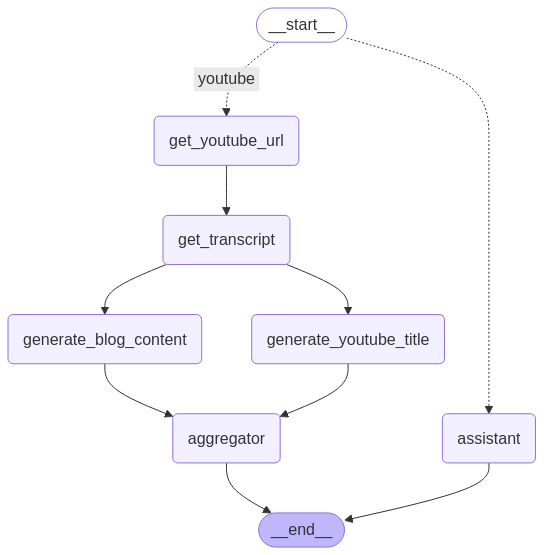

In [191]:
workflow = StateGraph(BlogState)

workflow.add_node("assistant", assistant)
workflow.add_node("get_youtube_url", get_youtube_url)
workflow.add_node("get_transcript", get_transcript)
workflow.add_node("generate_youtube_title", generate_youtube_title)
workflow.add_node("generate_blog_content", generate_blog_content)
workflow.add_node("aggregator", aggregator)

workflow.add_conditional_edges(
    START,
    query_router,
    {
        "youtube": "get_youtube_url",
        "assistant": "assistant"
    }
)
workflow.add_edge("get_youtube_url", "get_transcript")
workflow.add_edge("get_transcript", "generate_youtube_title")
workflow.add_edge("get_transcript", "generate_blog_content")
workflow.add_edge("generate_youtube_title", "aggregator")
workflow.add_edge("generate_blog_content", "aggregator")

workflow.add_edge("aggregator", END)
workflow.add_edge("assistant", END)

blog_app = workflow.compile()

blog_app

In [192]:
blog = blog_app.invoke(
    input={
        'user_message': "Write a blog on this youtube url : https://youtu.be/Uwmp16aSgdk?si=7b7BhG5N1wjZgkGw"
    }
)


\--------------------  QUERY ROUTER  --------------------


Write a blog on this youtube url : https://youtu.be/Uwmp16aSgdk?si=7b7BhG5N1wjZgkGw
<class 'str'>
E1

\--------------------  GET YOUTUBE URL  --------------------


https://youtu.be/Uwmp16aSgdk?si=7b7BhG5N1wjZgkGw

\--------------------  GET YOUTUBE TRANSCRIPT  --------------------



\--------------------  GENERATE BLOG CONTENT  --------------------



\--------------------  GENERATE YOUTUBE TITLE  --------------------




In [193]:
blog

{'user_message': 'Write a blog on this youtube url : https://youtu.be/Uwmp16aSgdk?si=7b7BhG5N1wjZgkGw',
 'youtube_url': 'https://youtu.be/Uwmp16aSgdk?si=7b7BhG5N1wjZgkGw',
 'youtube_transcript': 'upbeat music - All right, I think we can make this pretty short and sweet. The Mac team is on one? See, the M4 Mac Mini refresh was already one of the best tech deals of all 2024, great computer, great price. So now here comes this new M4 MacBook Air. Its the most capable, powerful version yet, obviously, thanks to the new chip. The starting memory is 16 gigs, it gets a sneaky, slightly larger battery, some Thunderbolt improvements, a new webcam, a new color, and the price goes down. Its kind of funny looking back a bit at the arc of reviewing MacBook Airs over the years. Like at first, it was this spectacle of engineering, but also kind of impractical and missing a few ports. It went from that to being, you know, a bit of an outdated design, but improving a lot. Then turned into basically the

In [195]:
# Markdown(blog['final_blog'])

In [197]:
blog = blog_app.invoke(
    input={
        'user_message': "https://youtu.be/gJucq3oGq30?si=K3avYoL7KZy1OK19"
    }
)


\--------------------  QUERY ROUTER  --------------------


https://youtu.be/gJucq3oGq30?si=K3avYoL7KZy1OK19
<class 'str'>
E1

\--------------------  GET YOUTUBE URL  --------------------


https://youtu.be/gJucq3oGq30?si=K3avYoL7KZy1OK19

\--------------------  GET YOUTUBE TRANSCRIPT  --------------------



\--------------------  GENERATE BLOG CONTENT  --------------------



\--------------------  GENERATE YOUTUBE TITLE  --------------------




In [198]:
Markdown(blog['final_blog'])

# How to Get Access to Manis AI: My Success Strategy

# Accessing Manis AI: How I Got My Invite Code and What It Can Do

## Introduction

Artificial intelligence tools are evolving rapidly, and Manis AI represents one of the most exciting developments in this space. As an invite-only AI agent that launched just a few weeks ago, Manis AI has generated significant buzz among tech enthusiasts and professionals alike. Unlike conventional AI chatbots, Manis AI operates on its own virtual computer, enabling it to create, interpret, and generate new files with remarkable sophistication. In this article, I'll share how I successfully secured an invitation after several failed attempts and provide insights into some of the platform's impressive capabilities.

## What Makes Manis AI Special?

Manis AI stands out from other AI tools due to its advanced capabilities for handling complex, multi-step analysis. While many AI assistants can answer questions or generate content, Manis AI takes functionality to the next level by operating within its own virtual environment. This allows it to:

- Process and analyze data across multiple formats
- Create and modify files independently
- Execute complex tasks that require multiple sequential steps
- Maintain context throughout extended problem-solving sessions

This functionality makes it particularly valuable for data analysis, report generation, and automating complex workflows that would typically require human intervention across multiple applications.

## How I Successfully Got My Invite Code

After several unsuccessful attempts at securing an invitation, I finally received access within 24-36 hours of my latest application. Here's the exact process I followed:

1. Navigate to the Manis AI website and click "Get Started"
2. Select "Join the Waitlist" on the subsequent page
3. Enter your email address (I used a personal Gmail account)
4. Complete the use case section with a specific, structured response

The use case description appears to be the critical factor in the application process. Based on my experience and conversations with others who have gained access, here's what worked:

- I structured my response in three clear paragraphs
- I focused on how I would use Manis AI for personal learning and business automation
- I kept my description specific yet concise
- I avoided mentioning any professional affiliations

### What to Avoid in Your Application

Through my multiple attempts and conversations with other users, I've identified several potential red flags that might delay your approval:

- Using work email addresses
- Listing professional titles or company affiliations
- Including social media accounts (despite some suggestions to do so)
- Providing vague or overly technical use cases

My successful application left the social media fields completely blank and focused solely on practical applications for the technology.

## Real-World Applications: What I've Been Testing

Since gaining access, I've been exploring Manis AI's capabilities with some practical tests. One particularly impressive example involved regulatory reporting for a fictional chocolate sales business.

I provided Manis AI with:
- An Excel spreadsheet containing chocolate sales data
- A set of fictional regulatory requirements for disclosure
- Instructions to analyze the data and prepare a compliant report

The AI demonstrated impressive analytical capabilities by:
1. Interpreting both the data and regulatory requirements
2. Performing necessary calculations independently
3. Generating a structured Word document with key findings
4. Creating relevant graphs and visualizations based on the data

What makes this process remarkable is that Manis AI handled the entire workflow without requiring me to switch between applications or manually process any of the information. The system maintained context throughout the task and delivered a polished final product.

## Beyond Basic Analysis: Other Potential Use Cases

While I'm still exploring Manis AI's full potential, several promising use cases have already become apparent:

- **Document Analysis and Summarization**: Processing lengthy documents and extracting key insights
- **Data Transformation**: Converting information between different formats and structures
- **Automated Reporting**: Generating regular reports from dynamic data sources
- **Content Creation**: Developing multimedia content with integrated research
- **Process Automation**: Handling multi-step workflows that would typically require human supervision

The platform's ability to maintain context while working across different file types and analytical processes makes it particularly valuable for tasks that would traditionally require switching between multiple applications.

## Conclusion

Manis AI represents a significant step forward in AI assistant technology, offering capabilities that go well beyond simple text generation or data analysis. Its ability to operate within its own virtual environment allows for sophisticated multi-step processes that were previously impossible with conventional AI tools.

If you're interested in exploring Manis AI for yourself, I recommend following the application approach outlined above, focusing particularly on providing a clear, specific use case that demonstrates how you would leverage the platform's unique capabilities. While the invite-only status makes access somewhat exclusive, a thoughtful application appears to significantly improve your chances of approval.

As AI tools continue to evolve, platforms like Manis AI offer a glimpse into a future where artificial intelligence can handle increasingly complex workflows with minimal human supervision. Whether you're looking to automate business processes, enhance data analysis capabilities, or simply explore the cutting edge of AI technology, Manis AI presents an exciting opportunity worth pursuing.

In [12]:
api = "" or "q" or None

In [13]:
print(api)

q
